<a href="https://colab.research.google.com/github/vheastman/ChallengerOringFailures/blob/master/SwitchboardDSPractical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Switchboard Data Science Practical

Date: February 5th, 2023

## Prompt 1

**Prompt 1**: Based on the provided data, what aspects of message sends seem most relevant to engagement? If you were going to provide direct guidance to customers running messaging programs, what would you tell them (if anything)?

### Outline of work below

In this notebook, I have done some brief EDA to explore the data provided in the two csv files. Based on that exploration, I have made some decisions about what to include and exclude from my initial model to determine the factors most important in user engagment with messaging campaigns. 

#### Assumptions and Observations:
- Based on the data dictionary, I'm assuming the [broadcast_id, organization_id] combination can be used to identify distinct messaging campaigns.
- The `created` column in the actions table corresponds to when the action was taken and can be used to compare to the `sent_time` column in the messages table. This assumption was not validated by the data and several messages had `sent_time` after the action time so this was left out of my initial modelling. 
- The data dictionary says that only messages that contain the tracking parameter can be tracked for the desired follow-up actions. Therefore, I have removed messages that do not contain the tracking parameter. 
- Similarly, I noticed that some messages did not have a `sent_time` even though all messages are designed as having been delivered. Since this is an important data point in my model below, I've removed entries that do not have a `sent_time` value. 
- Message type was included in the dataset, however, once I did the initial cleaning described above, the only messages that were left were sms messages. Further investigation should be done to optimize message type, especially because mms messages have a greater opportunity for dynamic and personalized messaging. 

#### Model inputs: 

At the bottom of this notebook, I have run two simple logistic regression models to understand the impact of the following variables on message clicks and donations. 

- Send hour of day
- Message length in number of words
- Send day of week

#### Model results:

According to the model, the factors that have a positive impact on message click or donation actions are the hour of the day in which the message was sent and the message length. Much more work should be done to validate these results, further refine the model, and explore other inputs to ensure our findings are accurate and thorough. 

## Prompt 2

**Prompt 2**: Based on your exploration of this data set, what other questions do you have? What would you want to collect more data on (or spend more time with this data) to understand better, and/or what questions would you have for customers, our customer-facing employees, or other folks on the team to help us help our customers run better programs?

If I had more time, I would like to look into the following ideas: 
- Clean and incorporate the timedeltas between message send and message action: Can we observe that users are more likely to take the desired action if they do so immediately after recieving the message. Would this impact when we send messages so users are in a position to more easily take action?
- Message content: specifically looking at sentiment of the message and other factors like how many strongly encouraging words are included in a message and how that impacts the actions that are taken. 
- Clear CTA: Is the desired action clearly defined in the message? Is the follow-up action easy to accomplish or is the failure of follow-up action the result of a poor user experience further down the pipeline?
- Personalization: Does the message contain a personalized element such as name?
- Geography (using area codes)
- [not in this data] Audience optimization: Can we use demographic data of the message recipients to optimize who we are sending to in order to drive more follow-up actions?


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
## Connect to data in google drive

# Code to read csv file into Colaboratory:
#!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
## Read in csvs
#https://drive.google.com/file/d/1FOguMSbGk26jlzkc-RMZHCM_4sl0t51F/view?usp=share_link
#https://drive.google.com/file/d/12bgmU-bOCu9xu_TmhA0Pzfk6L4mCRaba/view?usp=share_link

downloaded = drive.CreateFile({'id':'1FOguMSbGk26jlzkc-RMZHCM_4sl0t51F'}) 
downloaded.GetContentFile('actions.csv')  
df_a = pd.read_csv('actions.csv')

downloaded = drive.CreateFile({'id':'12bgmU-bOCu9xu_TmhA0Pzfk6L4mCRaba'}) 
downloaded.GetContentFile('messages.csv')  
df_m = pd.read_csv('messages.csv')

In [5]:
## Make some adjustments to the dfs

# Convert appropriate columns to timestamps:
for col in ['created', 'modified']:
  df_m[col] = pd.to_datetime(df_m[col])
  df_a[col] = pd.to_datetime(df_a[col])

df_m['sent_time'] = pd.to_datetime(df_m['sent_time'])

In [6]:
## What size is the data?
print(df_a.shape)
print(df_m.shape)

(733650, 11)
(2783096, 18)


In [7]:
####### Data Validation
## Which columns are empty?
print("Actions Table:")
for col in df_a.columns:
  print(col + ": " + str(df_a[col].isnull().all(axis=0)))

print()
print("Messages Table:")
for col in df_m.columns:
  print(col + ": " + str(df_m[col].isnull().all(axis=0)))


Actions Table:
id: False
created: False
modified: False
action: False
metadata: True
referrer: True
user_agent: False
query_parameters: True
ip: False
phone_message_id: False
organization_id: False

Messages Table:
id: False
created: False
modified: False
text: False
is_from_contact: False
send_status: False
broadcast_id: False
organization_id: False
phone_contact_id: False
provider: False
provider_message_id: False
provider_messaging_service_sid: False
error_code: True
error_message: True
message_type: False
sent_time: False
from_number: True
to_number: False


In [35]:
## Drop empty columns to help with memory issues:
for col in df_m.columns:
  if df_m[col].isnull().all(axis=0):
    df_m = df_m.drop(col, axis=1)

## Remove rows with a missing `sent_date`
df_m = df_m[df_m.sent_time.notna()]

## Only keep rows for messages with the tracking parameter in them
df_m = df_m[df_m['text'].str.contains("\?t=")]

In [9]:
# ## Look at the data
# print("Actions Table:")
# print(df_a.head())

# print("Messages Table:")
# print(df_m.head())

In [10]:
### Data Validation
## Question: Do all messages with a 'Donation' action also have a 'Click' action?
print(df_a.action.value_counts())
print()
print("Do all messages with a 'Donation' action also have a 'Click' action?")
set(df_a.loc[df_a['action'] == 'DONATION','phone_message_id']).issubset(set(df_a.loc[df_a['action'] == 'CLICK','phone_message_id']))

## Answer: Yes! One message can have both action types

CLICK       520344
DONATION    213306
Name: action, dtype: int64

Do all messages with a 'Donation' action also have a 'Click' action?


True

In [13]:
## Merge tables to get actions with raw message data
for act in ['CLICK', 'DONATION']:
  df_m = pd.merge(df_m, df_a.loc[df_a['action'] == act,['phone_message_id', 'action', 'created']], how = 'left', left_on='id', right_on='phone_message_id')
  df_m = df_m.rename(columns={'action': act.lower(), "created_y": act.lower() + "_time", "created": act.lower() + "_time"})
  df_m = df_m.drop('phone_message_id', axis=1)

## Turn them into booleans
df_m.loc[df_m['click'] == 'CLICK', 'click'] = 1
df_m.loc[df_m['donation'] == 'DONATION', 'donation'] = 1
df_m['click'] = df_m['click'].fillna(0)
df_m['donation'] = df_m['donation'].fillna(0)

In [14]:
## Delete actions table bc I'm having runtime errors. 
del df_a

In [16]:
##### Check some assumptions
# Does the action table `created` column capture the timestamp of when the action was taken?
print("Is the action table's 'created' timestamp always later than the 'sent_time' timestamp?")
print()
print("CLICKS:")
dfc = df_m.loc[df_m.click == 1]
print((dfc['sent_time'] < dfc['click_time']).value_counts())
print(str(round(((dfc['sent_time'] < dfc['click_time']).value_counts()[0] / dfc.shape[0])*100,2)) + "% of messages have a negative time delta between when they were sent and when the click action was taken.")

print()
print("DONATIONS:")
dfd = df_m.loc[df_m.donation == 1]
print((dfd['sent_time'] < dfd['donation_time']).value_counts())
print(str(round(((dfd['sent_time'] < dfd['donation_time']).value_counts()[0] / dfd.shape[0])*100,2)) + "% of messages have a negative time delta between when they were sent and when the click action was taken.")

Is the action table's 'created' timestamp always later than the 'sent_time' timestamp?

CLICKS:
True     484080
False      3563
dtype: int64
0.73% of messages have a negative time delta between when they were sent and when the click action was taken.

DONATIONS:
True     192351
False       166
dtype: int64
0.09% of messages have a negative time delta between when they were sent and when the click action was taken.


#### Success by Campaign

In [17]:
## Identify the number and size of each message campaigns
cmpns = pd.DataFrame(df_m.groupby(['broadcast_id', 'organization_id']).size()).reset_index()
cmpns.columns = ['broadcast_id', 'organization_id', 'message_count']
cmpns = cmpns.sort_values(by=['message_count'], ascending=False).reset_index().drop('index', axis=1)

Text(0.5, 1.0, 'Volume of Messages Sent in Each Messaging Campaign')

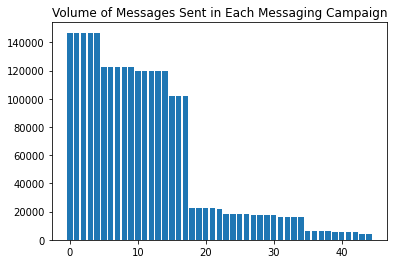

In [18]:
### Plot the message send size
plt.bar(cmpns.index,cmpns.message_count)
plt.title('Volume of Messages Sent in Each Messaging Campaign')

In [19]:
## Calculate click and donation rates for each campaign
for col in ['click', 'donation']:
  df_ = pd.DataFrame(df_m.groupby(['broadcast_id', 'organization_id']).apply(lambda x: (x[x[col] == 1].shape[0] / x.shape[0])) * 100).reset_index()
  df_.columns = ['broadcast_id', 'organization_id', col + '_rate']
  cmpns = pd.merge(cmpns, df_, how = 'left', left_on=['broadcast_id', 'organization_id'], right_on=['broadcast_id', 'organization_id'])

Text(0.5, 1.0, 'Click Rate vs Message Count')

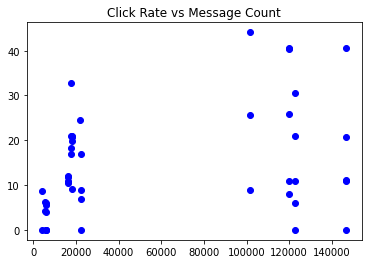

In [20]:
plt.plot(cmpns.message_count,cmpns.click_rate, 'bo')
plt.title("Click Rate vs Message Count")

Text(0.5, 1.0, 'Donation Rate vs Message Count')

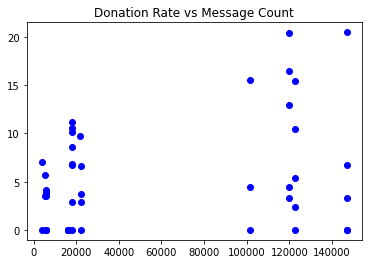

In [21]:
plt.plot(cmpns.message_count,cmpns.donation_rate, 'bo')
plt.title("Donation Rate vs Message Count")

## Create Features 

Outcomes:
*   Click
*   Donation

Inputs: 
*   Time of day (int): hour of the day extracted from `sent_time`
*   Day of week (boolean): Day of week dummy variables extracted from `sent_time` 
*   Message length (int): number of words in each message


(Additional inputs too consider if there was more time):
* *   Message Type (boolean): Dummy variable created from `message_type` column  
* Organization (boolean): Dummy variables created from `organization_id` column
*   Broadcast (boolean): Dummy variables created from `broadcast_id` column
*   Click time since send (timedelta): timedelta from `sent_time` to `click_time`
*   Donation time since send (timedelta): timedelta from `sent_time` to `donation_time`
*   Personalization (boolean): Dummy variable created from `text` column if there's a first name in the text of the message.  


In [22]:
## Only keep necessary columns
df = df_m[['click', 'donation', 'sent_time', 'organization_id', 'broadcast_id', 'message_type', 'click_time', 'donation_time', 'text']]

Text(0.5, 1.0, 'Histogram of Hour the Message was Sent')

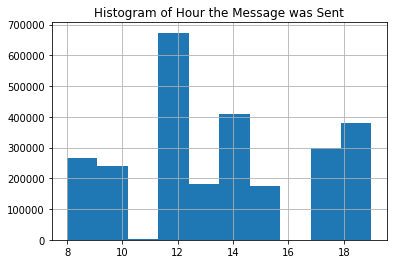

In [66]:
## Extract hour of day from `sent_time`
df['sent_hour_of_day'] = [i.hour for i in df['sent_time']]

# Plot histogram to see values
df.sent_hour_of_day.hist()
plt.title("Histogram of Hour the Message was Sent")

In [24]:
## Create message type dummy variables
df = df.join(df['message_type'].astype(str).str.get_dummies())

Text(0.5, 1.0, 'Histogram of Day of the Week the Message was Sent')

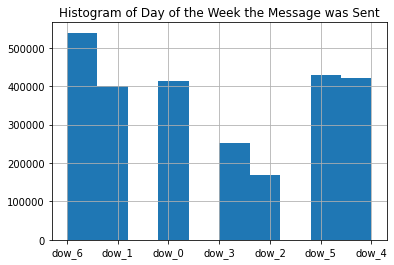

In [67]:
## Create day of week dummy variables
df['dayofweek'] = ["dow_" + str(i.dayofweek) for i in df['sent_time']]
#df = df.join(df['dayofweek'].astype(str).str.get_dummies())

## Plot values
df['dayofweek'].hist()
plt.title("Histogram of Day of the Week the Message was Sent")

Text(0.5, 1.0, 'Histogram of Length of the Messages')

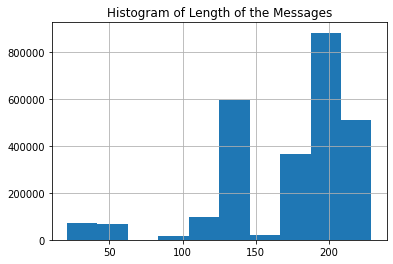

In [68]:
## Create message length variable
df['message_legth'] = [len(i.split(' ')) for i in df['text']]

## Plot values
df['message_legth'].hist()
plt.title("Histogram of Length of the Messages")

In [26]:
# ## Create org_id dummy variables
# df['organization_id'] = ['org_' + str(i) for i in df['organization_id']]
# df = df.join(df['organization_id'].astype(str).str.get_dummies())

In [27]:
## Create broadcast_id dummy variables
# df['broadcast_id'] = ['msg_' + str(i) for i in df['broadcast_id']]
# df = df.join(df['broadcast_id'].astype(str).str.get_dummies())

#### I ran into runtime issues (collab is failing me...) so I'll have to add this as something to try with more time.


### Logistic Regression

$$
click = log(b_0 + b_1 * \text{sent hour of day} + b_2 * \text{message length} + b_3 * \text{Tuesday} + b_4 * \text{Wednesday} + b_5 * \text{Thursday} + b_6 * \text{Friday} + b_7 * \text{Saturday} + b_8 * \text{Sunday})
$$

*Defaults*:
* Day of week = Monday 
* Message type = SMS


In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [70]:
### Set x variables
x_vars = ['sent_hour_of_day', 'message_legth', 'dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5',
       'dow_6']

In [71]:
#### Build Models

## Define x and y
for col in ['click', 'donation']:
  print(col)
  x = df[x_vars]
  y = df[col]

  ## Run logistic regression model
  model = LogisticRegression(solver='liblinear', random_state=0)
  model.fit(x,y)

  print("Model results for message clicks: ")
  print(model.intercept_)
  print(model.coef_)

  print()
  print(confusion_matrix(y, model.predict(x)))
  print()
  print()

click
Model results for message clicks: 
[-2.92393691]
[[ 0.13178312  0.00444924 -1.70694692 -1.90280251 -1.51378764 -2.09475172
  -1.34786608 -0.92161185]]

[[2124718   14436]
 [ 483830    3813]]


donation
Model results for message clicks: 
[-3.94662322]
[[ 0.11930195  0.00322612 -2.18748217 -1.33635453 -1.04677498 -1.42301655
  -0.83378547 -0.40354995]]

[[2434280       0]
 [ 192517       0]]


